# Lab_03-1 회귀

### Context
#### Linear Regression
+ Linear Regression
+ Ridge Linear Regression(L1)
+ Lasso Linear Regression(L2)

#### Machine Learning Algorithm Based Regression
+ MLP Regression
+ Support Vector Machine Regression
+ RandomForest Regression
+ XGBoost Regression
+ LightGBM Regression

#### Evaluation
+ R<sup>2</sup>
+ MAE, MSE, RMSE

In [1]:
import os
from os.path import join
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import sklearn

import matplotlib.pyplot as plt

#### 데이터 정보
    FIFA_train.csv : 축구선수의 정보와 능력치 그리고 이적시장 가격이 포함된 데이터
    FIFA_test.csv : 축구선수의 정보와 능력치가 포함된 데이터 해당 데이터의 선수들의 이적료를 예측해 주시면 됩니다.
    submission.csv : 답안지의 형식

    id : 선수 고유의 아이디
    name : 이름
    age : 나이
    continent : 선수들의 국적이 포함되어 있는 대륙입니다
    contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
    position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
    prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
    reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
    stat_overall : 선수의 현재 능력치 입니다.
    stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
    stat_skill_moves : 선수의 개인기 능력치 입니다.
    value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다.

In [2]:
fifa_train = join('data', join('FIFA', 'train.csv'))
fifa_test  = join('data', join('FIFA', 'test.csv'))

In [3]:
data = pd.read_csv(fifa_train)

label = data['value']

x_test = pd.read_csv(fifa_test)

In [4]:
data.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [5]:
data.shape

(8932, 12)

In [6]:
data.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [8]:
x_test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [9]:
x_test.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000
mean,7846.258098,25.297806,1.143939,67.336991,72.107628,2.414838
std,4870.339361,4.628236,0.448465,6.908814,6.133428,0.781153
min,1.000000,16.000000,1.000000,47.000000,52.000000,1.000000
25%,3466.250000,22.000000,1.000000,63.000000,68.000000,2.000000
50%,7643.500000,25.000000,1.000000,67.000000,72.000000,2.000000
75%,11967.000000,29.000000,1.000000,72.000000,76.000000,3.000000
max,16943.000000,42.000000,5.000000,94.000000,95.000000,5.000000


In [10]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


##### 불필요한 컬럼 삭제

In [11]:
#######전처리 필요
data['contract_until'].unique()

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

In [12]:
data.drop(columns=['value', 'id', 'name'], inplace=True)

x_test.drop(columns=['id', 'name'], inplace=True)

##### 수치형 변수 컬럼 및 범주형 변수 컬럼

In [13]:
data.dtypes == 'O'

age                 False
continent            True
contract_until       True
position             True
prefer_foot          True
reputation          False
stat_overall        False
stat_potential      False
stat_skill_moves    False
dtype: bool

In [14]:
# DF.info에서 Object type을 가진 컬럼은 모두 범주형 변수
# Python 내장 함수 zip은 2개의 리스트를 묶어 병렬로 사용할 수 있도록 해줍니다.
# data.dtypes에 들어있는 각 컬럼의 type 값이 'O'이면 범주형 변수이므로 해당 값이 'O'인 경우 범주형 컬럼 리스트에 추가합니다.
cat_columns = [c for (c, t) in zip(data.dtypes.index, data.dtypes) if t == 'O'] 
num_columns = [c for c in data.columns if c not in cat_columns]

print('Categorical Columns: \n{}\n\n Numeric Columns: \n{}\n'.format(cat_columns, num_columns))

Categorical Columns: 
['continent', 'contract_until', 'position', 'prefer_foot']

 Numeric Columns: 
['age', 'reputation', 'stat_overall', 'stat_potential', 'stat_skill_moves']



In [15]:
# zip 함수 예시 주석 해제해서 실행해보세요. 
# 당연히 두 리스트의 길이가 다르면 정상적으로 사용할 수 없습니다. a 혹은 b 리스트 중 한쪽에만 값을 추가하거나 제거해서 실행해보세요.

a = [1, 3, 4, 6, 9]
b = [2, 4, 5, 7, 10]

for (value1, value2) in zip(a, b):
    print(value1, value2)

1 2
3 4
4 5
6 7
9 10


### 실습 1 (20분)

1. 결측치 확인 및 결측치 처리
2. 스케일링
3. 범주형 변수 OneHot Encoding, 라벨 변수 스케일링 (log -> exp)

#### 1. 결측치 확인 및 결측치 처리 예시

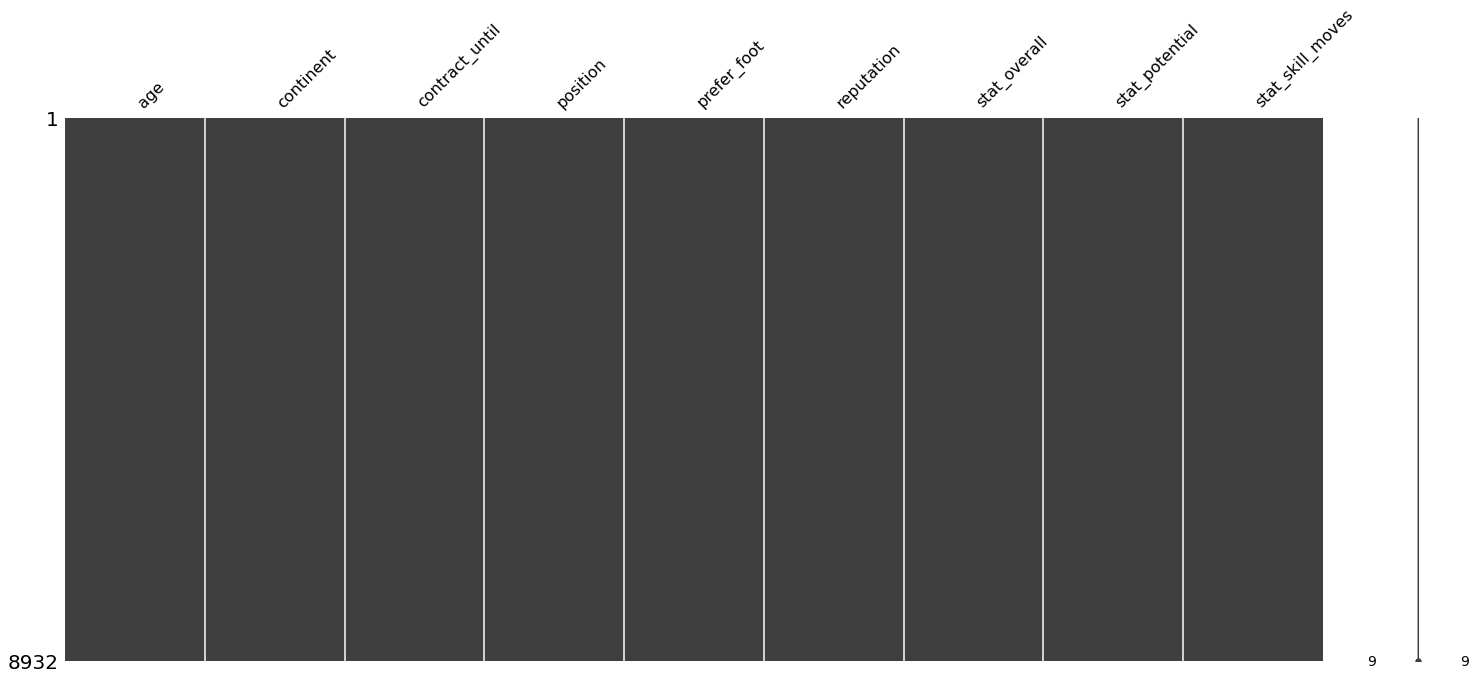

In [16]:
import missingno as msno
msno.matrix(data)

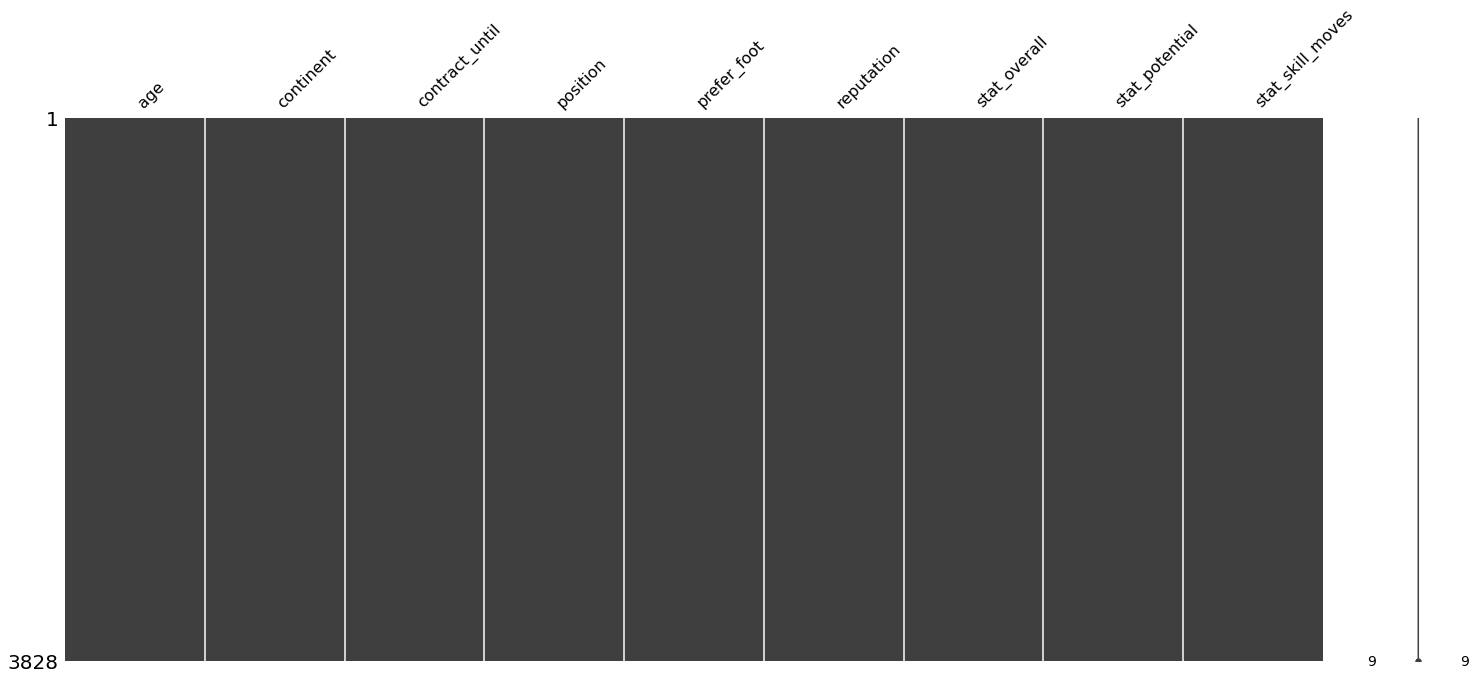

In [17]:
msno.matrix(x_test)

In [18]:
pd.isna(data).sum(), pd.isna(x_test).sum()

(age                 0
 continent           0
 contract_until      0
 position            0
 prefer_foot         0
 reputation          0
 stat_overall        0
 stat_potential      0
 stat_skill_moves    0
 dtype: int64,
 age                 0
 continent           0
 contract_until      0
 position            0
 prefer_foot         0
 reputation          0
 stat_overall        0
 stat_potential      0
 stat_skill_moves    0
 dtype: int64)

#### 2. 스케일링

In [19]:
data['contract_until'][-4:]

8928    2020
8929    2021
8930    2021
8931    2020
Name: contract_until, dtype: object

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(data, label, 
                                                      test_size=0.3,
                                                      random_state=2020,
                                                      shuffle=True)

In [21]:
label.shape

(8932,)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [23]:
scaler.fit(x_train[num_columns])

StandardScaler()

In [24]:
x_train_scaled = scaler.transform(x_train[num_columns])

In [25]:
scaler.transform(x_train[num_columns])

array([[-0.90782388, -0.30627812,  0.56165622,  1.32246812,  0.76761621],
       [ 1.23662577,  2.03175704,  1.28900092,  0.65676195, -0.51010917],
       [ 0.59329088, -0.30627812,  0.8525941 ,  0.15748232,  0.76761621],
       ...,
       [-1.12226884, -0.30627812,  0.8525941 ,  1.82174776, -1.78783456],
       [ 1.87996067, -0.30627812,  0.70712516, -0.00894423, -0.51010917],
       [-0.47893395, -0.30627812, -1.0385021 , -1.50678313, -0.51010917]])

In [26]:
x_valid_scaled = scaler.transform(x_valid[num_columns])
x_test_scaled = scaler.transform(x_test[num_columns])

In [27]:
x_train[num_columns] = x_train_scaled
x_valid[num_columns] = x_valid_scaled
x_test[num_columns] = x_test_scaled

In [28]:
x_train.head(),x_train.shape

(           age      continent contract_until position prefer_foot  reputation  \
 2615 -0.907824         europe   Jun 30, 2019       ST        left   -0.306278   
 822   1.236626         europe           2020       DF        left    2.031757   
 1829  0.593291  south america           2019       MF        left   -0.306278   
 4982 -0.693379         europe           2020       DF       right   -0.306278   
 6592  0.164401         europe           2019       MF       right   -0.306278   
 
       stat_overall  stat_potential  stat_skill_moves  
 2615      0.561656        1.322468          0.767616  
 822       1.289001        0.656762         -0.510109  
 1829      0.852594        0.157482          0.767616  
 4982     -0.165688        0.157482         -0.510109  
 6592     -0.602095       -1.173930         -0.510109  ,
 (6252, 9))

#### 3. 범주형 변수 OneHot Encoding, 라벨 변수 스케일링
- 범주형 변수 OneHot Encoding 처리, 이번에는 라벨이 수치형이므로 라벨은 인코딩하지 않습니다.
- 범주형 변수 중 "contract_until" 컬럼에 형태가 다른 범주 데이터가 있으니 DataFrame['contract_until'].unique()로 범주 값 확인 후 전처리 하세요.
- 예측할 변수의 값이 너무 큽니다. 이런 경우 라벨 변수를 스케일링 해줄 수 있는데, 이적료는 모두 양수이므로 log를 취해 예측할 라벨의 범위를 줄여줍니다.
    - 예측 후, exp를 취해 원래 스케일로 되돌려줄 수 있습니다.

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(x_train[cat_columns])

OneHotEncoder(sparse=False)

In [31]:
# ValueError: Found unknown categories ['Dec 31, 2019', 'Jun 1, 2019'] in column 1 during transform <- 에러 발생
# contract_until 컬럼의 범주 데이터 전처리

# new_x_train_cat = ohe.transform(x_train[cat_columns])
# new_x_valid_cat = ohe.transform(x_valid[cat_columns])
# new_x_test_cat = ohe.transform(x_test[cat_columns])

In [32]:
# 꼭 하나로 하지 않으셔도 됩니다. 전처리 후 바로 위 코드처럼 3개를 따로따로 진행하셔도 무방합니다.
x_all = pd.concat([x_train[cat_columns], x_valid[cat_columns], x_test[cat_columns]], axis=0)

# 이상한 범주 데이터 간단 전처리
x_all['contract_until'] = x_all['contract_until'].map(lambda x: x[-4:])

# fit과 transform을 한번에
new_x_all = ohe.fit_transform(x_all)

# ohe.categories_ 은 입력된 범주형 컬럼의 범주 값을 순서대로 담고 있습니다.
ohe_columns = ohe.categories_[0].tolist()
for idx in range(len(ohe.categories_)-1):
    ohe_columns += ohe.categories_[idx+1].tolist()
ohe_columns

['africa',
 'asia',
 'europe',
 'oceania',
 'south america',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024',
 '2025',
 '2026',
 'DF',
 'GK',
 'MF',
 'ST',
 'left',
 'right']

In [33]:
new_x_all.shape

(12760, 20)

In [34]:
len(ohe_columns)

20

In [35]:
new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)
new_x_all.head()

,africa,asia,europe,oceania,south america,2018,2019,2020,2021,2022,2023,2024,2025,2026,DF,GK,MF,ST,left,right
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [36]:
new_x_train_cat = new_x_all.iloc[:x_train.shape[0], :]
new_x_valid_cat = new_x_all.iloc[x_train.shape[0]:new_x_all.shape[0] - x_test.shape[0], :]
new_x_test_cat =  new_x_all.iloc[new_x_all.shape[0] - x_test.shape[0]:, :]

In [37]:
# train set 개수 확인
new_x_train_cat.shape, x_train.shape

((6252, 20), (6252, 9))

In [38]:
# valid set 개수 확인
new_x_valid_cat.shape, x_valid.shape

((2680, 20), (2680, 9))

In [39]:
# test set 개수 확인
new_x_test_cat.shape, x_test.shape

((3828, 20), (3828, 9))

In [40]:
# 동일하게 데이터를 쪼갤 시 인덱스를 초기화합니다.
new_x_train_cat.reset_index(drop=True, inplace=True)
new_x_valid_cat.reset_index(drop=True, inplace=True)
new_x_test_cat.reset_index(drop=True, inplace=True)

##### 기존 범주형 변수를 제거하고, Onehot Encoding된 변수를 추가합니다.

In [41]:
# 기존 범주형 변수 제거
x_train.drop(columns=cat_columns, inplace=True)
x_valid.drop(columns=cat_columns, inplace=True)
x_test.drop(columns=cat_columns, inplace=True)

In [42]:
# Onehot Encoding 변수 추가
x_train = pd.concat([x_train, new_x_train_cat], axis=1)
x_valid = pd.concat([x_valid, new_x_valid_cat], axis=1)
x_test = pd.concat([x_test, new_x_test_cat], axis=1)

In [43]:
# train 확인
x_train.head()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,africa,asia,europe,oceania,south america,...,2023,2024,2025,2026,DF,GK,MF,ST,left,right
0,1.236626,9.045863,3.907442,3.652440,2.045342,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.236626,9.045863,3.471035,3.153160,0.767616,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.451071,6.707827,3.471035,3.153160,0.767616,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,-0.050044,4.369792,3.325566,3.486013,-1.787835,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [44]:
# valid 확인
x_valid.head()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,africa,asia,europe,oceania,south america,...,2023,2024,2025,2026,DF,GK,MF,ST,left,right
0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.378846,6.707827,3.471035,3.486013,-1.787835,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [45]:
# test 확인
x_test.head()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,africa,asia,europe,oceania,south america,...,2023,2024,2025,2026,DF,GK,MF,ST,left,right
0,1.665516,9.045863,3.907442,3.652440,3.323067,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.164401,9.045863,3.616504,3.486013,3.323067,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.378846,6.707827,3.471035,3.319587,2.045342,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.378846,6.707827,3.471035,3.153160,2.045342,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.451071,6.707827,3.471035,3.153160,2.045342,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [46]:
x_test.describe()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,africa,asia,europe,oceania,south america,...,2023,2024,2025,2026,DF,GK,MF,ST,left,right
count,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,...,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000
mean,0.013819,0.030257,0.028802,0.008968,0.019940,0.076803,0.091432,0.592738,0.020115,0.218913,...,0.065569,0.000522,0.001045,0.000261,0.331766,0.107106,0.373824,0.187304,0.238506,0.761494
std,0.992502,1.048527,1.005018,1.020765,0.998099,0.266313,0.288259,0.491389,0.140412,0.413564,...,0.247560,0.022855,0.032313,0.016163,0.470909,0.309288,0.483881,0.390206,0.426226,0.426226
min,-1.980049,-0.306278,-2.929598,-3.337475,-1.787835,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.693379,-0.306278,-0.602095,-0.674650,-0.510109,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-0.050044,-0.306278,-0.020220,-0.008944,-0.510109,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.807736,-0.306278,0.707125,0.656762,0.767616,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,3.595520,9.045863,3.907442,3.818866,3.323067,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 라벨 변수 스케일링 log 스케일로 조정

In [47]:
y_train = np.log(y_train)
y_valid = np.log(y_valid)

## Linear Regression
선형 회귀는 종속 변수와 한개 이상의 독립 변수와의 선형 상관 관계를 모델링하는 회귀 분석 기법입니다. <br>
용어를 종속 변수, 독립 변수로 표현하면 이해하기 어려우니 다음 수식에서의 y, x 로 표현하겠습니다.<br> 

$$ y = wx + b$$
$$ y = w_0x_0 + w_1x_1 + w_2x_2 + .... w_nx_n + b$$
$$ w : 계수(가중치) $$
$$ b : 절편(편향) $$

간단하게 생각해보면 선형 회귀는 데이터가 분포되어 있는 공간에서 데이터를 가장 잘 표현하는 선을 하나 긋는다고 생각할 수 있습니다.<br>
선형 회귀의 비용 함수는 다음과 같이 표현될 수 있습니다.

$$ Cost_{lr} = \sum_i{(y_i - \hat y_i)^2}$$
$$ \hat y_i = b + wx_i $$

결국 실제 참값 $y_i$와 회귀 모델이 출력한 $ \hat y $ 사이의 잔차의 제곱의 합을 최소화하는 w(계수)를 구하는 것이 목적입니다. -> Least Square, 최소 제곱법 <br>
선형 회귀는 출력되는 y가 1개 또는 2개 이상인지의 유무에 따라 단변량, 다변량이라는 말이 붙는데, 이번 수업에서는 출력값인 y가 1개(단변량)라고 가정하겠습니다. <br>
또한, 입력으로 들어가는 x가 1개 또는 2개 이상인지의 유무에 따라 단순(Simple), 다중(Multiple)이라는 말이 붙는데, 이번 실습에서는 단순, 다중 선형 회귀 분석에 대해 모두 알아보겠습니다.

#### 선형 회귀분석의 4가지 기본 가정
선형 회귀에는 4가지 가정이 필요합니다. 우리 수업에서는 이론적인 내용을 다루지 않으므로, 추후에 살펴보시면 좋겠습니다.<br>
맨 아래 참조 목록에 4가지 가정에 대해 잘 설명해준 페이지의 링크를 달아두었습니다.
1. 선형성
2. 독립성
3. 등분산성
4. 정규성

### 1. Linear Regression

- 하나의 연속 변수를 예측하는 선형 회귀에는 "단순" 선형 회귀(Simple Linear Regression), "다중" 선형 회귀(Multiple Linear Regression)가 있습니다. "단순" 선형 회귀는 입력 데이터의 변수가 1개인 경우이고, "다중" 선형 회귀는 입력 데이터의 변수가 2개 이상인 경우 입니다.
- 일반적으로는 여러 변수를 사용하는 "다중" 회귀 분석이 되겠습니다.

Linear Regression은 Sklearn의 linear_model 패키지에 있습니다.

- Linear Regression 대표적 파라미터
    - fit_intercept (bool) : 회귀 수식에서 y 절편을 포함할지 유무

#### 1) 모델 불러오기 및 정의하기

In [48]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

#### 2) 모델 학습하기 (훈련 데이터)

In [50]:
pd.isna(x_train).sum()

age                 1849
reputation          1849
stat_overall        1849
stat_potential      1849
stat_skill_moves    1849
africa              1849
asia                1849
europe              1849
oceania             1849
south america       1849
2018                1849
2019                1849
2020                1849
2021                1849
2022                1849
2023                1849
2024                1849
2025                1849
2026                1849
DF                  1849
GK                  1849
MF                  1849
ST                  1849
left                1849
right               1849
dtype: int64

In [63]:
lr.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = lr.predict(x_valid)

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
from sklearn.metrics import r2_score

print('선형 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

#### 회귀 모델의 계수 w, 절편 b 살펴보기
어떤 변수에 얼마 만큼의 가중치가 할당되고, 절편 값은 얼마나 할당되는지 살펴볼 수 있습니다.

In [ ]:
print('다중 선형 회귀, 계수(w) : {}, 절편(b) : {:.4f}'.format(lr.coef_, lr.intercept_))

### 2. Lasso Linear Regression(L1)
이번에는 선형 회귀 모델의 가중치 크기에 규제를 적용하는 라쏘 선형 회귀 모델을 살펴보겠습니다.<br>
라쏘 선형 회귀 모델과 기존 선형 회귀 모델의 차이점으로는 손실 함수에 L1 정규화 항을 추가하는 것인데, 다음과 같습니다. 

$$ Cost_{lr} = \sum_i{(y_i - \hat y_i)^2} + \lambda \sum{|w|}$$

해당 식에서 w는 선형 회귀 모델이 가진 가중치 값으로, 학습을 통해 손실 함수를 최소화하면 각 가중치의 값도 작아지는 효과를 얻을 수 있습니다.<br>
이는 선형 회귀 모델의 과적합을 방지하는 요소로써 사용되어지는데, 가중치의 값이 클 경우 모델의 복잡도가 높아져서 과적합되는 경향이 있기 때문입니다. <br>
라쏘 선형 회귀는 몇몇 가중치의 값을 0으로 만드는 특징이 있습니다.

- Lasso Linear Regression 대표적 파라미터
    - alpha         (float): L1 규제를 얼마나 많이 적용할지에 대한 수치 
    - fit_intercept (bool) : 회귀 수식에서 y 절편을 포함할지 유무
    - random_state  (int)  : 내부적으로 사용되는 난수값

#### 1) 모델 불러오기 및 정의하기

In [ ]:
from sklearn.linear_model import Lasso
lasso_lr = Lasso()

#### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
lasso_lr.fit(x_train, y_train)

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = lasso_lr.predict(x_valid)

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
print('라쏘 선형 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

#### 회귀 모델의 계수 w, 절편 b 살펴보기
어떤 변수에 얼마 만큼의 가중치가 할당되고, 절편 값은 얼마나 할당되는지 살펴볼 수 있습니다.

In [ ]:
print('라쏘 선형 회귀, 계수(w) : {}, 절편(b) : {:.4f}'.format(lasso_lr.coef_, lasso_lr.intercept_))

### 3. Ridge Linear Regression(L2)
이번에는 선형 회귀 모델의 가중치 크기에 규제를 적용하는 릿지 선형 회귀 모델을 살펴보겠습니다.<br>
릿지 선형 회귀 모델과 기존 선형 회귀 모델의 차이점으로는 손실 함수에 L2 정규화 항을 추가하는 것인데, 다음과 같습니다. 

$$ Cost_{lr} = \sum_i{(y_i - \hat y_i)^2} + \lambda \sum{w^2}$$

해당 식에서 w는 선형 회귀 모델이 가진 가중치 값으로, 학습을 통해 손실 함수를 최소화하면 각 가중치의 값도 작아지는 효과를 얻을 수 있습니다.<br>
라쏘 선형 회귀와는 다르게 각 가중치의 값이 0이 아닌 0에 가까운 작은 수로 수렴하게 됩니다.

- Lasso Linear Regression 대표적 파라미터
    - alpha         (float): L2 규제를 얼마나 많이 적용할지에 대한 수치 
    - fit_intercept (bool) : 회귀 수식에서 y 절편을 포함할지 유무
    - random_state  (int)  : 내부적으로 사용되는 난수값

#### 1) 모델 불러오기 및 정의하기

In [ ]:
from sklearn.linear_model import Ridge
ridge_lr = Ridge()

#### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
ridge_lr.fit(x_train, y_train)

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = ridge_lr.predict(x_valid)

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
print('릿지 선형 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

#### 회귀 모델의 계수 w, 절편 b 살펴보기
어떤 변수에 얼마 만큼의 가중치가 할당되고, 절편 값은 얼마나 할당되는지 살펴볼 수 있습니다.

In [ ]:
print('릿지 선형 회귀, 계수(w) : {}, 절편(b) : {:.4f}'.format(ridge_lr.coef_, ridge_lr.intercept_))

## Machine Learning Algorithm Based Regression
이번에는 머신러닝 알고리즘을 기반으로한 회귀 모델에 대해 알아보겠습니다.<br>
Sklearn이 지원하는 머신러닝 기반 회귀 모델로는 결정 트리, 랜덤 포레스트, 서포트 벡터 머신, MLP, AdaBoost, Gradient Boosting 등이 있습니다.<br>
그 중 서포트 벡터 머신, MLP 및 랜덤 포레스트, XGBoost와 LightGBM 회귀 모델을 살펴보겠습니다.

### 1. Multi Layer Perceptron Regressor
딥러닝의 기본 모델인 뉴럴 네트워크를 기반으로 한 회귀 모델입니다. 기본적으로 MLP라 하면, 입력층-은닉층-출력층 3개로 이루어진 뉴럴 네트워크를 의미합니다.

![Feedforword](./img/Feedforword.png)

#### 어떻게 뉴럴 네트워크가 비선형 문제를 해결할 수 있을까?
은닉층에 존재하는 하나하나의 노드는 기본 선형 회귀 모델과 동일하게 $ wx + b $로 이루어져 있습니다. <br>
하지만 이런 선형 분리를 할 수 있는 모델을 여러개를 모아 비선형 분리를 수행하는 것이 뉴럴 네트워크 입니다.<br>

![HowNNSolve](./img/HowNNSolve.png)

아래 그림을 보면 4개의 벡터 공간을 선형 분리하는 퍼셉트론들이 하나의 비선형 공간을 분류할 수 있는 벡터 공간을 형성하는 것을 확인할 수 있습니다.<br>
직관적으로는 이해하기 어려우시겠지만, 우리가 케익을 4개의 퍼셉트론들이 분할하는 대로 잘라 가운데 부분을 남기는 것을 생각해보시면 되겠습니다.

MLP 회귀 모델은 Sklearn의 neural_network 패키지에 있습니다.

- Multi Layer Perceptron Regression 대표적 파라미터
    - hidden_layer_sizes  (list) : 은닉층의 구성을 결정
    - activation          (str)  : 활성화 함수의 종류
    - alpha               (float): L2 규제를 얼마나 많이 적용할지에 대한 수치
    - batch_size          (int)  : 미니 배치의 크기
    - learning_rate       (str)  : 훈련량의 형태 (상수형, 감소형, 적응형)
    - learning_rate_init  (float): 훈련량, 학습 시 모델을 얼마나 업데이트할지 결정하는 값
    - solver              (str)  : 옵티마이저를 결정
    - random_state  (int)  : 내부적으로 사용되는 난수값

#### 1) 모델 불러오기 및 정의하기

In [ ]:
from sklearn.neural_network import MLPRegressor
mlp_regr = MLPRegressor()

#### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
mlp_regr.fit(x_train, y_train)

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = mlp_regr.predict(x_valid)

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
print('단순 MLP 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

#### 회귀 모델의 계수 w, 절편 b 살펴보기
어떤 변수에 얼마 만큼의 가중치가 할당되고, 절편 값은 얼마나 할당되는지 살펴볼 수 있습니다.<br>
근본적으로는 MLP는 여러개의 선형 회귀모델 식으로 구성되어 있기 때문에 동일하게 계수와 절편 값을 확인할 수 있습니다.

In [ ]:
print('릿지 선형 회귀, 계수 및 절편(w, b) : {}'.format(mlp_regr.coefs_))

### 2. Support Vector Machine Regressor
서포트 벡터 머신의 기본 개념은 결정 경계와 가장 가까운 데이터 샘플의 거리(Margin)을 최대화 하는 방식으로 모델을 조정합니다.<br>
서포트 벡터 머신 회귀 모델은 Sklearn의 svm 패키지에 있습니다.

<img src="./img/SVM.png" alt="Support Vector machine" style="height: 400px" align='center'/>

### 왜 마진을 최대화 할까요?
서포트 벡터 머신에서 나오는 마진은 물건을 판매할때 마진이 20%다 라고 말하는 그 마진이 맞습니다. <br>
그렇다면 경계면과의 마진을 최대화 하는 것이 왜 분류를 잘하게 할까요? 

#### 경험적 위험 최소화(Empirical Risk Minimization, ERM) vs 구조적 위험 최소화(Structural Risk Minimization,SRM)
* 경험적 위험 최소화 
    * 훈련 데이터에 대해 위험을 최소화
    * 학습 알고리즘의 목표
    * 뉴럴 네트워크, 결정 트리, 선형 회귀, 로지스틱 회귀 등.
* 구조적 위험 최소화
    * 관찰하지 않은(Unseen) 데이터에 대해서도 위험을 최소화
    * 오차 최소화를 일반화 시키는 것
    
<div align='center'> 
    <font size="6">어떤 모델이 더 좋을까요?</font> 
</div>


<img src="./img/ERM_SRM.png" alt="ERM_SRM" style="height: 300px" align='center'/>


### Cost : Soft or Hard
SVM에는 Soft Margin, Hard Margin 이라는 말이 있습니다. 단어 자체에서도 유추할 수 있으시겠지만, Soft Margin은 유연한 경계면을 만들어내고 Hard Margin은 분명하게 나누는 경계면을 만들어냅니다. 그렇다면 왜 Soft Margin이 필요한걸까요?

<img src = "./img/Softmargin.png" alt="Softmargin" style="height: 400px" />

다음과 같은 데이터 분포는 직선으로 두개의 데이터를 나누는 경계면을 만들기 어렵습니다. 현실에서도 우리가 최적의 답을 찾지 못할때 어느정도 비용(Cost, C)을 감수하면서 적절한 답을 찾는 것을 떠올려보세요.<br>
Soft Margin은 그런 원리입니다. 경계면을 조금씩 넘어가는 데이터들(비용, Cost)을 감수하면서 가장 차선의 경계면을 찾습니다.<br>
실제 알고리즘에서도 C(Cost)값을 통해 얼마나 비용을 감수할 것인지를 결정할 수 있습니다. 크면 클수록 Hard Margin을, 작으면 작을수록 Soft Margin을 만들어냅니다. <br>


### 저차원을 고차원으로 Kernel Trick
SVM은 기본적으로 선형 분류를 위한 경계면을 만들어냅니다. 그렇다면 어떻게 비선형 분류를 할 수 있을까요?<br>

<img src = "./img/Hyperplane.png" alt="hyper" style="height: 300px" />

저차원(2차원)에서는 선형 분리가 되지 않을 수 있지만, 고차원(3차원)에서는 선형 분리가 가능할 수 있습니다.<br>
이러한 원리를 바탕으로 선형 분리가 불가능한 저차원 데이터를 선형 분리가 가능한 어떤 고차원으로 보내 선형 분리를 할 수 있습니다.<br>
하지만, 저차원 데이터를 고차원으로 보내서 서포트 벡터를 구하고 저차원으로 내리는 과정에서 더 복잡해지고 연산량도 많아질것이 분명합니다. <br>
그래서 여기에서 Kernel Trick이라는 Mapping 함수를 사용합니다. Kernel Trick은 고차원 Mapping과 고차원에서의 내적 연산을 한번에 할 수 있는 방법입니다. <br>
이를 통해 여러가지 Kernel 함수를 통해 저차원에서 해결하지 못한 선형 분리를 고차원에서 해결할 수 있습니다.<br>

대표적인 Kernel 함수
- Linear (선형 함수)
- Poly   (다항식 함수)
- RBF    (방사기저 함수)
- Hyper-Tangent (쌍곡선 탄젠트 함수)

서포트 벡터 머신 분류기는 Sklearn의 svm 패키지에 있습니다.

- SVM 대표적 파라미터
    - C             (float): 얼마나 모델에 규제를 넣을지 결정하는 값 작아질수록 모델에 규제가 높아짐 (과적합 방지, from SVM) 
    - degree        (int)  : Poly Kernel 사용 시, 차수를 결정하는 값
    - kernel        (str)  : Kernel trick에 사용할 커널 종류
    - random_state  (int)  : 내부적으로 사용되는 난수값
    - class_weight  (dict) : 학습 시 클래스의 비율에 맞춰 손실값에 가중치를 부여
    - gamma         (float): 모델이 생성하는 경계가 복잡해지는 정도 (값이 커질수록 데이터 포인터가 영향력을 행사하는 거리가 짧아져 경계가 복잡해진다.)

#### 1) 모델 불러오기 및 정의하기

In [ ]:
from sklearn.svm import SVR
svm_regr = SVR()

#### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
svm_regr.fit(x_train, y_train)

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = svm_regr.predict(x_valid)

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
print('단순 서포트 벡터 머신 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

### 3. Random Forest Regressor
트리 모델은 데이터의 불순도(impurity, Entropy)를 최소화 하는 방향으로 트리를 분기하여 모델을 생성합니다.<br>
이러한 트리를 모아 숲을 만든 모델이 랜덤 포레스트 입니다. 
분류 수업에서 배웠던 내용과 동일한 특성을 가지고 있습니다. 

<img src='./img/DTDesc.png' style="height: 400px"  />
<br>

* 사람의 논리적 사고 방식을 모사하는 분류 방법론
* IF-THEN rule의 조합으로 class 분류
* 결과를 나무 모양으로 그릴 수 있음
* Greedy 한 알고리즘 (한번 분기하면 이후에 최적의 트리 형태가 발견되더라도 되돌리지 않음, 최적의 트리 생성을 보장하지 않음)
* 축에 직교하는 분기점
* 데이터 전처리가 필요 없음

<img src='./img/DT_G.png' style="height: 400px"  />

#### 불순도(Impurity, Entropy)
결정 트리는 데이터의 불순도를 최소화 할 수 있는 방향으로 트리를 분기합니다. <br>
불순도란 정보 이론(Information Theory)에서 말하는 얻을 수 있는 정보량이 많은 정도를 뜻합니다. <br>
ex) 오늘 해가 동쪽에서 뜰꺼야 -> 낮은 정보량, 오늘 일식이 일어날꺼야 -> 높은 정보량 <br>
정보 이론의 정보량의 자세한 내용은 참조 목록에 링크로 남겨두겠습니다. 확인해보시면 좋겠습니다.


- RandomForest 대표적 파라미터
    - n_estimators      (int)  : 내부에서 생성할 결정 트리의 개수 
    - crierion          (str)  : 모델 학습 시 사용할 수식 (mse, rmse)
    - max_depth         (int)  : 생성할 트리의 높이
    - min_samples_split (int)  : 분기를 수행하는 최소한의 데이터 수
    - max_leaf_nodes    (int)  : 리프 노드에서 가지고 있을 수 있는 최대 데이터 수
    - random_state      (int)  : 내부적으로 사용되는 난수값
    - n_jobs            (int)  : 병렬처리에 사용할 CPU 수
    - class_weight      (dict) : 학습 시 클래스의 비율에 맞춰 손실값에 가중치를 부여

#### 1) 모델 불러오기 및 정의하기

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regr = RandomForestRegressor()

#### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
rf_regr.fit(x_train, y_train)

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = rf_regr.predict(x_valid)

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
print('랜덤 포레스트 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

### 실습 (10분)
#### 위에서 사용한 것과 같이 XGBoost, LightGBM 모델을 사용해보세요.

### 4. XGBoost Regressor
Random Forest는 전체 데이터 샘플과 변수를 사용하는 것이 아닌, 임의로 데이터 샘플 및 변수를 선택하여 학습하는 부트스트래핑(Bootstrapping) 방식의 앙상블 알고리즘 입니다.<br>
XGBoost는 이름에서도 알 수 있듯 각 이터레이션에서 맞추지 못한 샘플에 대해 가중치를 부여하여 모델을 학습시키는 부스팅(Boosting) 계열의 트리 모델입니다.<br>
부스팅 알고리즘 자체도 강력하지만, XGBoost는 강력한 병렬 처리 성능과 자동 가지치기(Pruning) 알고리즘이 적용되어 기존 부스팅 알고리즘보다 과적합 방지에 이점이 있습니다.<br>
또한 자체 교차검증 알고리즘과 결측치 자체처리 기능을 가지고 있습니다. 
다른 부스팅 알고리즘과 동일하게 `균형 트리 분할 방식`으로 모델을 학습하여 대칭적인 트리를 형성하게됩니다.

1. Gradient Boosting Model 대비 빠른 수행시간
2. 과적합 규제 기능(Regularization)
3. 가지치기 기능(Tree pruning)
4. 자체 내장 교차 검증 기능
5. 결측치 자체 처리(결측치 처리를 하지 않아도 모델 사용 가능)
6. Early Stopping 기능

- XGBoost 대표적 파라미터
    - n_estimators      (int)  : 내부에서 생성할 결정 트리의 개수 
    - max_depth         (int)  : 생성할 결정 트리의 높이
    - learning_rate     (float): 훈련량, 학습 시 모델을 얼마나 업데이트할지 결정하는 값
    - colsample_bytree  (float): 열 샘플링에 사용하는 비율
    - subsample         (float): 행 샘플링에 사용하는 비율
    - reg_alpha         (float): L1 정규화 계수
    - reg_lambda        (float): L2 정규화 계수
    - booster           (str)  : 부스팅 방법 (gblinear / gbtree / dart)
    - random_state      (int)  : 내부적으로 사용되는 난수값
    - n_jobs            (int)  : 병렬처리에 사용할 CPU 수

#### 1) 모델 불러오기 및 정의하기

In [ ]:
# from xgboost import XGBRegressor
# xgb_reg = 

#### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
# xgb_reg.

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
# y_pred = xgb_reg.

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
# print('XGBoost 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

### 5. LightGBM Regressor
XGBoost가 기존의 부스팅 트리 모델보다는 학습이 빠르다는 장점이 있지만, 여전히 속도가 느린 알고리즘입니다. <br>
LightGBM은 XGBoost보다 가볍고 더 나은 학습 성능을 제공하며, 더 적은 메모리를 사용합니다. <br>
다른 부스팅 트리와는 다른 특징으로 `균형 트리 분할 방식`으로 모델을 학습시키는 것이 아닌 `리프 중심 트리 분할`방식을 사용해 비대칭적인 트리를 형성하게 됩니다. <br>
예측 성능 자체는 XGBoost와 비슷하지만 학습 속도 및 메모리 사용량에서 이점을 갖습니다. 

1. XGBoost의 장점 + 
2. XGBoost 보다 가볍고 빠른 모델, 하지만 더 나은 학습 성능
3. Leaf-wise tree growth (대체적으로 더 나은 성능을 보장하지만, 적은 데이터에서 과적합 우려)

- LightGBM 대표적 파라미터
    - n_estimators      (int)  : 내부에서 생성할 결정 트리의 개수 
    - max_depth         (int)  : 생성할 결정 트리의 높이
    - learning_rate     (float): 훈련량, 학습 시 모델을 얼마나 업데이트할지 결정하는 값
    - colsample_bytree  (float): 열 샘플링에 사용하는 비율
    - subsample         (float): 행 샘플링에 사용하는 비율
    - reg_alpha         (float): L1 정규화 계수
    - reg_lambda        (float): L2 정규화 계수
    - boosting_type     (str)  : 부스팅 방법 (gbdt / rf / dart / goss)
    - random_state      (int)  : 내부적으로 사용되는 난수값
    - n_jobs            (int)  : 병렬처리에 사용할 CPU 수

#### 1) 모델 불러오기 및 정의하기

In [ ]:
# from lightgbm import LGBMRegressor
# lgb_regr = 

#### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
# lgb_regr.

#### 3) 결과 예측하기 (검증 데이터)

In [ ]:
# y_pred = lgb_regr.

#### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
# print('LightGBM 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

## Evaluation
### R<sup>2</sup>
Scikit-Learn에서 지원하는 회귀 모델의 평가 방법으로는 R<sup>2</sup>가 있습니다. <br>
학습한 회귀 모델이 얼마나 데이터를 잘 표현하는지에 대한 정도를 나타내는 통계적인 척도이며, 0 < R<sup>2</sup> < 1 범위의 값을 갖습니다.<br>

<img src = './img/R2.png' alt='R2' align='left' height=500 width=500 /> 

$$ R^2 = 1 - {SSE \over SST} $$

* R<sup>2</sup> = 1, 모델이 데이터를 완벽하게 표현함 (Fits perfectly)
* R<sup>2</sup> = 0, 모델이 데이터를 전혀 표현하지 못함 (Does not explain anything)

### Mean Absolute Error(MAE)
MAE는 회귀 모델에서 자주 사용되는 손실 함수 입니다. <br>
MAE는 오차(정답과 예측값의 차이)의 절대 값에 대해 평균을 취한 결과 입니다. 수식은 다음과 같습니다.
$${{1}\over{n}} \sum_{i=1}^n{(|y_i - \hat{y}_i|)}$$

### Mean Squared Error(MSE)
MSE는 회귀 모델에서 자주 사용되는 손실 함수로 다음과 같은 수식으로 구성되어 있습니다. <br>
이름에서 알 수 있듯 MAE가 오차의 절대값을 사용했다면, 오차를 제곱해서 평균을 취한 결과입니다. 
$${{1}\over{n}} \sum_{i=1}^n{(y_i - \hat{y}_i)^2}$$

### Root Mean Squared Error(RMSE)
RMSE는 MSE에 Square root를 씌운것과 같습니다. 수식은 다음과 같습니다. <br>

$$\sqrt{{{1}\over{n}} \sum_{i=1}^n{(y_i - \hat{y}_i)^2}}$$

#### 실습, 위에서 사용한 모델 중 하나를 선택해 4개 평가 지표에 대해 확인해보세요 (5분)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
# 실습

In [ ]:
print('r2_score : {:.3f}'.format(r2_score(y_valid, y_pred)))
print('MAE      : {:.6f}'.format(mean_absolute_error(y_valid, y_pred)))
print('MSE      : {:.6f}'.format(mean_squared_error(y_valid, y_pred)))
print('RMSE     : {:.6f}'.format(mean_squared_error(y_valid, y_pred)))

### Reference
- 선형 회귀의 기본 가정 : https://kkokkilkon.tistory.com/175
- Wikipedia, Linear Regression : https://ko.wikipedia.org/wiki/선형_회귀
- Wikipedia, R-Square : https://en.wikipedia.org/wiki/Coefficient_of_determination
- Sklearn, Boston dataset : https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html
- Sklearn, Linear Regression : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- Sklearn, Decision Tree Regression : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- Sklearn, Support Vector Machine Regression : https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
- Sklearn, MLP Regression : https://www.google.com/url?q=http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html&sa=U&ved=0ahUKEwjsntScreDhAhWMfbwKHWBXAbIQFggOMAU&client=internal-uds-cse&cx=016639176250731907682:tjtqbvtvij0&usg=AOvVaw3lJrRpqB9lWv_Fd98pGuJD
- Sklearn, R-Square : https://www.google.com/url?q=http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html&sa=U&ved=0ahUKEwicgu3vueDhAhUI9LwKHeLDD3UQFggEMAA&client=internal-uds-cse&cx=016639176250731907682:tjtqbvtvij0&usg=AOvVaw3JYUuCpR-KNsPU189XgvWR
- R2: https://jihongl.github.io/2017/09/16/Rsquared/
- MAE, MSE: https://blog.naver.com/PostView.nhn?blogId=heygun&logNo=221516529668&parentCategoryNo=&categoryNo=56&viewDate=&isShowPopularPosts=true&from=search
- RMSE: https://ko.wikipedia.org/wiki/평균_제곱근_편차

## 실습 솔루션

### 1) 전처리 실습 

#### 1. 결측치 확인 및 결측치 처리 예시

In [ ]:
import missingno as msno

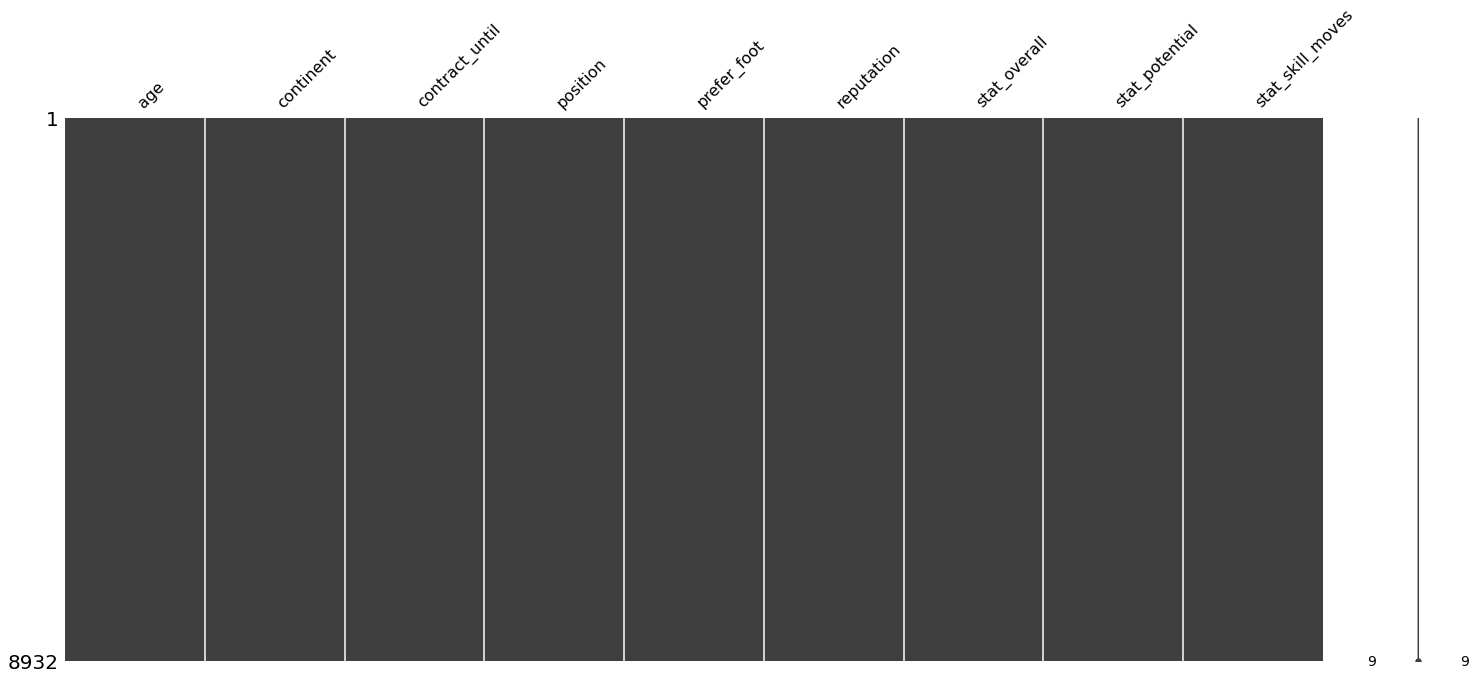

In [51]:
msno.matrix(data)

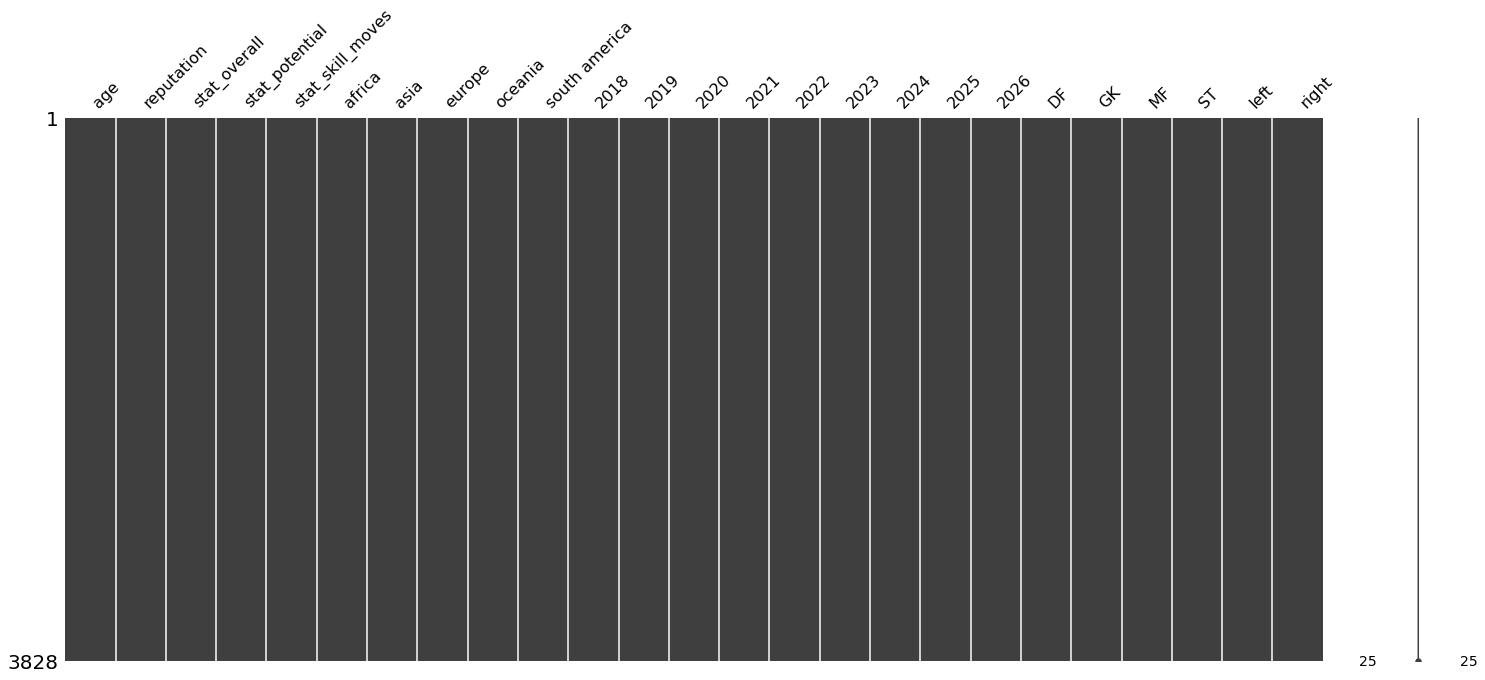

In [52]:
msno.matrix(x_test)

##### 수치형 변수들의 결측치 확인

In [53]:
pd.isna(data[num_columns]).sum()

age                 0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

In [54]:
pd.isna(x_test[num_columns]).sum()

age                 0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

##### 범주형 변수들의 결측치 확인

In [55]:
pd.isna(data[cat_columns]).sum()

continent         0
contract_until    0
position          0
prefer_foot       0
dtype: int64

In [56]:
pd.isna(x_test[cat_columns]).sum()

KeyError: "None of [Index(['continent', 'contract_until', 'position', 'prefer_foot'], dtype='object')] are in the [columns]"

결측치가 없으므로 그대로 넘어가셔도 됩니다.

##### 데이터 쪼개기, Train -> (Train, Valid)
- train_test_split 파라미터 
    - test_size  (float): Valid(test)의 크기의 비율을 지정
    - random_state (int): 데이터를 쪼갤 때 내부적으로 사용되는 난수 값 (해당 값을 지정하지 않으면 매번 달라집니다.)
    - shuffle     (bool): 데이터를 쪼갤 때 섞을지 유무
    - stratify   (array): Stratify란, 쪼개기 이전의 클래스 비율을 쪼개고 나서도 유지하기 위해 설정해야하는 값입니다. 클래스 라벨을 넣어주면 됩니다.
        - ex) 원본 Train 데이터의 클래스 비율이 (7:3) 이었다면, 쪼개어진 Train, Valid(test) 데이터의 클래스 비율도 (7:3)이 됩니다. 당연히 분류 데이터에서만 사용할 수 있습니다.
        - 이번에는 분류 문제가 아니므로 일반적으로는 stratify를 사용할 수 없습니다.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# 쪼개어진 Train, Valid 데이터의 비율은 (7:3), 내부 난수 값 2020, 데이터를 쪼갤 때 섞으며 label 값으로 Stratify 하는 코드 입니다. random_state를 주석 처리하고 데이터를 확인해보시면 계속 바뀝니다.
x_train, x_valid, y_train, y_valid = train_test_split(data, label, 
                                                      test_size=0.3,
                                                      random_state=2020,
                                                      shuffle=True)

In [ ]:
# 쪼갠 데이터의 인덱스는 정리해주는것이 좋습니다. pd.concat 연산 시, 인덱스를 기준으로 연결하기 때문입니다.
# drop 인자를 True로 주지 않으면 이전 인덱스가 새로운 변수로 생성됩니다.
x_train.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)

##### 전처리하기 결측치 확인 및 결측치 처리
- x_train 데이터의 평균값(수치형 변수)과 최빈값(범주형 변수)을 이용해 x_train, x_valid 데이터의 결측값을 처리해줍니다.

In [ ]:
x_train_mean = np.mean(x_train[num_columns], axis=0)
x_train_mode = x_train[cat_columns].mode()

In [ ]:
x_train_mean

In [ ]:
x_train_mode

In [ ]:
for c in num_columns:
    # x_train의 평균 값으로 x_train, x_valid 수치형 변수 결측치 처리
    x_train.loc[pd.isna(x_train[c]), c] =  x_train_mean[c]
    x_valid.loc[pd.isna(x_valid[c]), c] =  x_train_mean[c]
    x_test.loc[pd.isna(x_test[c]), c]   =  x_train_mean[c]
    
for c in cat_columns:
    # x_train의 최빈 값으로 x_train, x_valid 범주형 변수 결측치 처리
    x_train.loc[pd.isna(x_train[c]), c] =  x_train_mode[c][0]
    x_valid.loc[pd.isna(x_valid[c]), c] =  x_train_mode[c][0]
    x_test.loc[pd.isna(x_test[c]), c]   =  x_train_mode[c][0]

In [ ]:
pd.isna(x_train).sum().sum(), pd.isna(x_valid).sum().sum(), pd.isna(x_test).sum().sum()

##### x_train, x_valid, x_test에 대해 스케일링 및 범주형 변수 인코딩을 진행해보세요.

#### 2. 스케일링

In [ ]:
x_train_mean = np.mean(x_train[num_columns], axis=0)
x_train_std  = np.std(x_train[num_columns], axis=0)

# Numpy 브로드캐스팅 기능을 활용해 x_train의 평균과 표준편차로 x_train, x_valid의 스케일링을 진행해줍니다.
x_train.loc[:, num_columns] = (x_train[num_columns] - x_train_mean) / x_train_std 
x_valid.loc[:, num_columns] = (x_valid[num_columns] - x_train_mean) / x_train_std
x_test.loc[:, num_columns] = (x_test[num_columns] - x_train_mean) / x_train_std

#### 스케일링 확인

In [ ]:
x_train[num_columns].describe()

In [ ]:
x_valid[num_columns].describe()

In [ ]:
x_test[num_columns].describe()

#### 왜 x_valid와 x_test는 평균이 0, 표준편차가 1이 아닌가요? -> x_train의 평균과 표준편차를 사용했기 때문에 x_valid의 평균과 표준편차가 0, 1이 아닐 수 있습니다.

#### 3. 범주형 변수 OneHot Encoding, 라벨 변수 스케일링
- 범주형 변수 OneHot Encoding 처리, 이번에는 라벨이 수치형이므로 라벨은 인코딩하지 않습니다.
- 범주형 변수 중 "contract_until" 컬럼에 형태가 다른 범주 데이터가 있으니 DataFrame['contract_until'].unique()로 범주 값 확인 후 전처리 하세요.
- 예측할 변수의 값이 너무 큽니다. 이런 경우 라벨 변수를 스케일링 해줄 수 있는데, 이적료는 모두 양수이므로 log를 취해 예측할 라벨의 범위를 줄여줍니다.
    - 예측 후, exp를 취해 원래 스케일로 되돌려줄 수 있습니다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(x_train[cat_columns])

In [ ]:
# ValueError: Found unknown categories ['Dec 31, 2019', 'Jun 1, 2019'] in column 1 during transform <- 에러 발생
# contract_until 컬럼의 범주 데이터 전처리

# new_x_train_cat = ohe.transform(x_train[cat_columns])
# new_x_valid_cat = ohe.transform(x_valid[cat_columns])
# new_x_test_cat = ohe.transform(x_test[cat_columns])

In [ ]:
# 꼭 하나로 하지 않으셔도 됩니다. 전처리 후 바로 위 코드처럼 3개를 따로따로 진행하셔도 무방합니다.
x_all = pd.concat([x_train[cat_columns], x_valid[cat_columns], x_test[cat_columns]], axis=0)

# 이상한 범주 데이터 간단 전처리
x_all['contract_until'] = x_all['contract_until'].map(lambda x: x[-4:])

# fit과 transform을 한번에
new_x_all = ohe.fit_transform(x_all)

# ohe.categories_ 은 입력된 범주형 컬럼의 범주 값을 순서대로 담고 있습니다.
ohe_columns = ohe.categories_[0].tolist()
for idx in range(len(ohe.categories_)-1):
    ohe_columns += ohe.categories_[idx+1].tolist()
ohe_columns

In [ ]:
new_x_all.shape

In [ ]:
len(ohe_columns)

In [ ]:
new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)
new_x_all.head()

In [ ]:
new_x_train_cat = new_x_all.iloc[:x_train.shape[0], :]
new_x_valid_cat = new_x_all.iloc[x_train.shape[0]:new_x_all.shape[0] - x_test.shape[0], :]
new_x_test_cat =  new_x_all.iloc[new_x_all.shape[0] - x_test.shape[0]:, :]

In [ ]:
# train set 개수 확인
new_x_train_cat.shape, x_train.shape

In [ ]:
# valid set 개수 확인
new_x_valid_cat.shape, x_valid.shape

In [ ]:
# test set 개수 확인
new_x_test_cat.shape, x_test.shape

In [ ]:
# 동일하게 데이터를 쪼갤 시 인덱스를 초기화합니다.
new_x_train_cat.reset_index(drop=True, inplace=True)
new_x_valid_cat.reset_index(drop=True, inplace=True)
new_x_test_cat.reset_index(drop=True, inplace=True)

##### 기존 범주형 변수를 제거하고, Onehot Encoding된 변수를 추가합니다.

In [ ]:
# 기존 범주형 변수 제거
x_train.drop(columns=cat_columns, inplace=True)
x_valid.drop(columns=cat_columns, inplace=True)
x_test.drop(columns=cat_columns, inplace=True)

In [ ]:
# Onehot Encoding 변수 추가
x_train = pd.concat([x_train, new_x_train_cat], axis=1)
x_valid = pd.concat([x_valid, new_x_valid_cat], axis=1)
x_test = pd.concat([x_test, new_x_test_cat], axis=1)

In [ ]:
# train 확인
x_train.head()

In [ ]:
# valid 확인
x_valid.head()

In [ ]:
# test 확인
x_test.head()

In [ ]:
x_test.describe()

#### 라벨 변수 스케일링 log 스케일로 조정

In [ ]:
y_train = np.log(y_train)
y_valid = np.log(y_valid)

##### 인코딩 전처리 끝

### 2) 모델 실습

#### XGBoost

##### 1) 모델 불러오기 및 정의하기

In [ ]:
from xgboost import XGBRegressor
xgb_regr = XGBRegressor()

##### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
xgb_regr.fit(x_train, y_train)

##### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = xgb_regr.predict(x_valid)

##### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
print('XGBoost 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

#### LightGBM

##### 1) 모델 불러오기 및 정의하기

In [ ]:
from lightgbm import LGBMRegressor
lgb_regr = LGBMRegressor()

##### 2) 모델 학습하기 (훈련 데이터)

In [ ]:
lgb_regr.fit(x_train, y_train)

##### 3) 결과 예측하기 (검증 데이터)

In [ ]:
y_pred = lgb_regr.predict(x_valid)

##### 4) 결과 살펴보기
일반적으로 선형회귀 R<sup>2</sup>를 평가 척도로 사용합니다.<br>
R<sup>2</sup>값이 1에 가까울수록 회귀 모델이 데이터를 잘 표현한다는 것을 의미합니다.

In [ ]:
print('LightGBM 회귀, R2 : {:.4f}'.format(r2_score(y_valid, y_pred)))

#### 평가 지표

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:
# xgboost ver
xgb_regr = XGBRegressor(n_estimators=1000,
                        max_depth=8
                       )

xgb_regr.fit(x_train, y_train)

y_pred = xgb_regr.predict(x_valid)

In [ ]:
print('r2_score : {:.3f}'.format(r2_score(y_valid, y_pred)))
print('MAE      : {:.6f}'.format(mean_absolute_error(y_valid, y_pred)))
print('MSE      : {:.6f}'.format(mean_squared_error(y_valid, y_pred)))
print('RMSE     : {:.6f}'.format(np.sqrt(mean_squared_error(y_valid, y_pred))))